<a href="https://colab.research.google.com/github/kylemath/DeepEEG/blob/master/notebooks/DeepEEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DeepEEG


#Connect to Google Drive

In [1]:
#mount google drive to load own images, follow link and get code and paste in below
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#Install and Setup 

In [2]:
!pip install mne
from mne import pick_types, viz, io, Epochs 
from mne import channels, find_events, concatenate_raws
from mne import read_evokeds
from mne.time_frequency import tfr_morlet

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.precision = 4

import numpy as np
from numpy import genfromtxt

from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,12)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.layers import Flatten, Conv2D, MaxPooling2D, LSTM
from keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

#install ngork
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


    100% |████████████████████████████████| 6.2MB 7.1MB/s 
  Running setup.py bdist_wheel for mne ... - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/59/23/bb/ebafe2eae31064edfb9b384131abd0ec562a9418601cde6d69
Successfully built mne


Using TensorFlow backend.


--2019-01-29 14:38:44--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.4.75.11, 54.165.51.142, 52.45.111.123, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.4.75.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  3.44MB/s    in 1.5s    

2019-01-29 14:38:47 (3.44 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


#Utilities

In [0]:
#find the factors of a number |to add extra dimension for CNN|
def factors(n):
      return [i for i in range(1, n + 1) if not n%i]
  
##Setup TensorFlow
def SetupTensorFlow():
  
  #run tensorboard
  LOG_DIR = './log'
  get_ipython().system_raw(
      'tensorboard --logdir {} --host 0.0.0.0 --port 6007 &'
      .format(LOG_DIR)
  )

  #run ngork
  get_ipython().system_raw('./ngrok http 6007 &')

  #get url
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
      "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


#Load data function

In [0]:
#load in data files
def load_data(filename,plot_sensors=True,plot_raw=True,plot_raw_psd=True,stim_channel=False):
  
  raw = io.read_raw_brainvision(filename, 
                          montage='standard_1020', 
                          eog=('HEOG', 'VEOG'), 
                          preload=True,stim_channel=stim_channel)
  
  #set sampling rate
  sfreq = raw.info['sfreq']
  print('Sampling Rate = ' + str(sfreq))
  
  #load channel locations
  print('Loading Channel Locations')
  if plot_sensors:
    raw.plot_sensors(show_names='True')

  ##Plot raw data
  if plot_raw:
    raw.plot(n_channels=16, block=True)

   #plot raw psd 
  if plot_raw_psd:
    raw.plot_psd(fmin=.1, fmax=100 ) 
  
  return raw, sfreq

#Preprocessing Function

In [0]:
def preprocess(raw, event_id, event_names, plot_psd=True, filter_data=True, 
               eeg_filter_highpass=1, plot_events=True, epoch_time=(-1,2), 
               baseline=(-.2,0), rej_thresh_uV=100,
               epoch_decim=1, plot_electrodes=True,
               plot_erp=True):

  nsfreq = sfreq/epoch_decim #create new output freq for after epoch or wavelet decim
  tmin=epoch_time[0] 
  tmax=epoch_time[1] 
  eeg_filter_lowpass = nsfreq/2.5  #lower to avoid aliasing from decim

  #Filtering

  if filter_data:             
    print('Filtering Data')
    raw.filter(eeg_filter_highpass,eeg_filter_lowpass, 
               method='iir', verbose='WARNING' )
  
  if plot_psd:
    raw.plot_psd(fmin=eeg_filter_highpass, fmax=nsfreq/2 ) 
   
  #artifact rejection
  rej_thresh = rej_thresh_uV*1e-6

  #Epoching
  events = find_events(raw,shortest_event=1)
  color = {event_nums[0]: 'red', event_nums[1]: 'black'}

  #plot event timing
  if plot_events:
    viz.plot_events(events, sfreq, raw.first_samp, color=color,
                        event_id=event_id)

  #Constructevents
  epochs = Epochs(raw, events=events, event_id=event_id, 
                  tmin=tmin, tmax=tmax, baseline=baseline, 
                  preload=True,reject={'eeg':rej_thresh},
                  verbose=False, decim=epoch_decim)
  print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
   
  if plot_electrodes or plot_erp:
    evoked_zero = epochs[event_names[0]].average()
    evoked_one = epochs[event_names[1]].average()  
  
  ## plot ERP at each electrode
  if plot_electrodes:
    pick = pick_types(epochs.info, meg=False, eeg=True, eog=False)
    fig_zero = evoked_zero.plot(spatial_colors=True, picks=pick)
    fig_zero = evoked_one.plot(spatial_colors=True, picks=pick)

  ## plot ERP in each condition on same plot
  if plot_erp:
    evoked_dict = dict()
    evoked_dict[event_names[0]] = evoked_zero
    evoked_dict[event_names[1]] = evoked_one
    colors = dict(Standard="Red", Target="Blue")
    pick = evoked_dict[event_names[0]].ch_names.index('Pz')
    viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                                 split_legend=True)

  return epochs



#FeatureEngineer Function

Takes epochs object as input and settings, outputs training, test and val data
option to use frequency or time domain

In [0]:
def FeatureEngineer(epochs,frequency_domain=1,
                    normalization=True,
                    wavelet_decim=1,flims=(3,30),
                    f_bins=20,wave_cycles=6,
                    spect_baseline=[-1,-.5],
                    electrodes_out=[11,12,13,14,15],
                    test_split = 0.2, val_split = 0.2,
                    random_seed=1017, model_type='NN'):
  
  #Training Settings
  num_classes = len(event_names)
  np.random.seed(random_seed)

  if frequency_domain:
    print('Constructing Frequency Domain Features')
    f_low = flims[0]
    f_high = flims[1]
    frequencies =  np.linspace(f_low, f_high, f_bins, endpoint=True)

    ## Condition0 ##
    print('Computing Morlet Wavelets on ' + event_names[0])
    tfr0 = tfr_morlet(epochs[event_names[0]], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=False,
                          picks=electrodes_out,average=False,decim=wavelet_decim)
    tfr0 = tfr0.apply_baseline(spect_baseline,mode='mean')
    stim_onset = np.argmax(tfr0.times>0)
    new_times = tfr0.times[stim_onset:]
    #reshape data
    cond0_power_out = np.moveaxis(tfr0.data[:,:,:,stim_onset:],1,3) #move electrodes last
    cond0_power_out = np.moveaxis(cond0_power_out,1,2) # move time second
    #cond0_power_out[:,0:5,0:5,:] = 0 #for testing model add mark to image
    print('Condition zero trials: ' + str(len(cond0_power_out)))
    print(event_names[0] + ' Time Points: ' + str(len(new_times)))
    print(event_names[0] + ' Frequencies: ' + str(len(tfr0.freqs)))

    ## Condition1 ##
    print('Computing Morlet Wavelets on ' + event_names[1])
    tfr1 = tfr_morlet(epochs[event_names[1]], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=False,
                          picks=electrodes_out,average=False,decim=wavelet_decim)
    tfr1 = tfr1.apply_baseline(spect_baseline,mode='mean')   
    #reshape data
    cond1_power_out = np.moveaxis(tfr1.data[:,:,:,stim_onset:],1,3)
    cond1_power_out = np.moveaxis(cond1_power_out,1,2) # move time second
    #cond1_power_out[:,0:5,0:5,:] = 1 #for testing model add mark to image
    print('Condition one trials: ' + str(len(cond1_power_out)))    
    print(event_names[1] + ' Time Points: ' + str(len(new_times)))
    print(event_names[1] + ' Frequencies: ' + str(len(tfr1.freqs)))
    X = np.append(cond0_power_out,cond1_power_out,0);

    #reshape to trials x times x variables for LSTM and NN model
    if model_type != 'CNN':
      X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2] * X.shape[3]),order='F')
    
    #Append Data
    Y_class = np.append(np.zeros(len(cond0_power_out)), np.ones(len(cond1_power_out)),0)


  if not frequency_domain:
    print('Constructing Time Domain Features')

    X = np.moveaxis(epochs._data[:,:-3,:],1,2); #put channels last, remove eye and stim

    #take post baseline only
    stim_onset = np.argmax(epochs.times>0)
    new_times = epochs.times[stim_onset:]
    X = X[:,stim_onset:,:]

    # reshape for CNN, factor middle dimensions
    if model_type == 'CNN' and not frequency_domain:
      all_factors = factors(X.shape[1])
      X = np.reshape(X, (X.shape[0], int(X.shape[1]/all_factors[2]), all_factors[2], X.shape[2]),order='F')

    Y_class = epochs.events[:,2]-1  #subtract 1 to make 0 and 1
    
  #Normalize X - need to save mean and std for future test + val
  if normalization:
    print('Normalizing X')
    X = (X - np.mean(X)) / np.std(X)
    
  # convert class vectors to one hot Y and recast X
  Y = keras.utils.to_categorical(Y_class, num_classes)
  X = X.astype('float32')

  # Split training test and validation data 
  val_prop = val_split / (1-test_split)
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_split,random_state=random_seed) 
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_prop, random_state=random_seed)

  # Compute model input shape
  input_shape = X.shape[1:]
  
  #compute class weights for uneven classes
  y_ints = [y.argmax() for y in y_train]
  class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)
  
  #Print some outputs
  print('Combined X Shape: ' + str(X.shape))
  print('Combined Y Shape: ' + str(Y_class.shape))
  print('Y Example (should be 1s & 0s): ' + str(Y_class[0:10]))
  print('X Range: ' + str(np.min(X)) + ':' + str(np.max(X)))
  print('Input Shape: ' + str(input_shape))
  print('x_train shape:', x_train.shape)
  print(x_train.shape[0], 'train samples')
  print(x_test.shape[0], 'test samples')
  print(x_val.shape[0], 'validation samples')
  print('Class Weights: ' + str(class_weights))

  return x_train,x_test,x_val,y_train,y_test,y_val,input_shape,num_classes,class_weights


#CreateModel Function

In [0]:
def CreateModel(input_shape,num_classes,model_type='NN',batch_size=1):
  print('Creating ' +  model_type + ' Model')

  if model_type == 'LSTM':
    ##---LSTM - Many to two, sequence of time to classes
    units = [input_shape[1], 100, 100, 100, 100, num_classes]
    model = Sequential()
    model.add(LSTM(input_shape=(None, units[0]) ,units=units[1], return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units[2],return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units[3],return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units[4],return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=units[5]))
    model.add(Activation("softmax"))

  if model_type == 'NN':
    ##---DenseFeedforward Network
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.20))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.20))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.20))
       
    model.add(Dense(num_classes, activation='softmax'))

  if model_type == 'CNN':
    ##----Convolutional Network
    model = Sequential()
    model.add(Conv2D(10, (3, 3), input_shape=input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))


  # initiate adam optimizer
  opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                              epsilon=None, decay=0.0, amsgrad=False)

  # Let's train the model using RMSprop
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])  

  return model



#TrainTestVal Function

In [0]:
def traintestval(model,class_weights,x_train,x_test,x_val,y_train,y_test,y_val,batch_size=1,train_epochs=20):
  print('Training Model:')

  #Train Model
  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=train_epochs,
            validation_data=(x_val, y_val),
            shuffle=True,
            verbose=True,
            class_weight=class_weights
            )

  #Summarize
  model.summary()


  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.semilogy(history.history['loss'])
  plt.semilogy(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()



  # Test on left out Test data
  score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
  print(model.metrics_names)
  print('Test loss:', score)
  print('Test accuracy:', acc)

#Run Loading Data

*  Each data file is from a condition in an EEG experiment, from folder in google drive


In [9]:
#Data Settings#
exp = 'bikepark'
conditions = ['quiet','traffic']
path = 'gdrive/My Drive/data/'
subs = ['005', '007', '009', '010', '012', '013', '014', '015', '016', '019']

#
#subs = ['002','003','004','005','007','009','010','011', '012',
#        '013','014','015','016','017', '018']
for isub,sub in enumerate(subs):        
  for icond, condition in enumerate(conditions):
    fname = path + exp + '/' + sub + '_' + exp + '_' + condition + '.vhdr'
    tempraw,sfreq = load_data(fname,plot_sensors=False,plot_raw=False,plot_raw_psd=False,stim_channel=True)
    if icond==0 and isub==0:
      raw = tempraw
    else:
      raw.append(tempraw)

Extracting parameters from gdrive/My Drive/data/bikepark/005_bikepark_quiet.vhdr...
Setting channel info structure...
Reading 0 ... 952379  =      0.000 ...  1904.758 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S255', 'Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S 11', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/005_bikepark_traffic.vhdr...
Setting channel info structure...
Reading 0 ... 980079  =      0.000 ...  1960.158 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S  4', 'Stimulus/S 13', 'Stimulus/S  5', 'Stimulus/S 11', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/007_bikepark_quiet.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 771 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 982359  =      0.000 ...  1964.718 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S  4', 'Stimulus/S 13', 'Stimulus/S 11', 'Stimulus/S 10', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/007_bikepark_traffic.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1199 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 879709  =      0.000 ...  1759.418 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/009_bikepark_quiet.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1206 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 1372879  =      0.000 ...  2745.758 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S255', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S  1', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 11', 'Stimulus/S  6', 'Stimulus/S  7']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/009_bikepark_traffic.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1208 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 853929  =      0.000 ...  1707.858 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S  1', 'Stimulus/S  4', 'Stimulus/S 13', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/010_bikepark_quiet.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1208 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 971479  =      0.000 ...  1942.958 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S 11', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/010_bikepark_traffic.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1209 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 1214799  =      0.000 ...  2429.598 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/012_bikepark_quiet.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1205 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 863459  =      0.000 ...  1726.918 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S 11', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/012_bikepark_traffic.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1210 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 1577229  =      0.000 ...  3154.458 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S 11', 'Stimulus/S  4', 'Stimulus/S 13', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/013_bikepark_quiet.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1806 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 1308179  =      0.000 ...  2616.358 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 11', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/013_bikepark_traffic.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1204 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 1015009  =      0.000 ...  2030.018 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 11', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/014_bikepark_quiet.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1207 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 1219869  =      0.000 ...  2439.738 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S  4', 'Stimulus/S 11', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/014_bikepark_traffic.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1195 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 1391329  =      0.000 ...  2782.658 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S 11', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 15', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/015_bikepark_quiet.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1201 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 1262439  =      0.000 ...  2524.878 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S255', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 11', 'Stimulus/S  6', 'Stimulus/S  7']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/015_bikepark_traffic.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1209 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 940909  =      0.000 ...  1881.818 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S  4', 'Stimulus/S 11', 'Stimulus/S  5', 'Stimulus/S 15', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/016_bikepark_quiet.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1211 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 936189  =      0.000 ...  1872.378 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S  4', 'Stimulus/S 11', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 15', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/016_bikepark_traffic.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1209 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 1292389  =      0.000 ...  2584.778 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S255', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 11', 'Stimulus/S 15', 'Stimulus/S  6', 'Stimulus/S  7']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/019_bikepark_quiet.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1214 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 926969  =      0.000 ...  1853.938 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S 11', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/019_bikepark_traffic.vhdr...


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1208 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...
Reading 0 ... 973459  =      0.000 ...  1946.918 secs...


<ipython-input-4-68ca958fb78f>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S  1', 'Stimulus/S255', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S 11', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7']
Sampling Rate = 500.0
Loading Channel Locations


<ipython-input-9-a3d859806408>:16: RuntimeWarning: Omitted 1228 annotation(s) that were outside data range.
  raw.append(tempraw)


#Run Preprocessing

Filtering Data
24733 events found
Event IDs: [  1   2   3   4   5   6   7   9  10  11  13  15 255]
sample drop %:  48.56264909230582


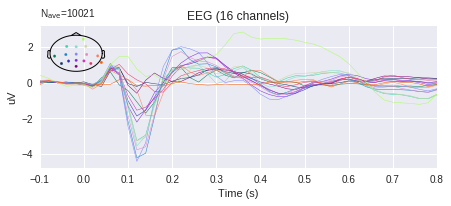

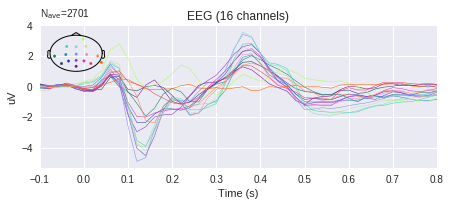

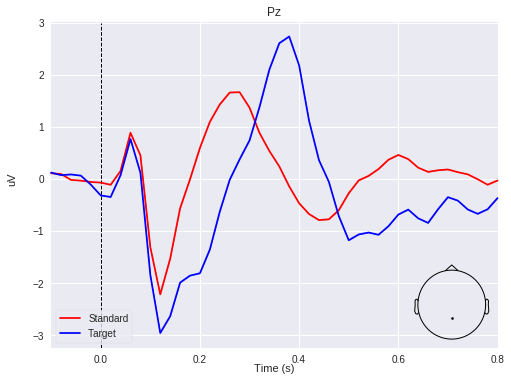

In [14]:
##Preprocessing Settings
event_names = ['Standard','Target']
event_nums = [1,2] # 1 Standard, 2 Target, 9 Response
event_id = {event_names[0]: event_nums[0], event_names[1]: event_nums[1]} #create dict

#keep epoch_decim=1 if using frequency_domain

epochs = preprocess(raw, event_id, event_names, plot_psd=False, filter_data=True, 
               eeg_filter_highpass=1, plot_events=False, epoch_time=(-.1,.8), 
               baseline=(-.1,0), rej_thresh_uV=150,
               epoch_decim=10, plot_electrodes=True,
               plot_erp=True)


#Run FeatureEngineer

In [23]:
x_train, x_test, x_val, y_train, y_test, y_val, input_shape, num_classes, class_weights = FeatureEngineer( epochs,
                    frequency_domain=0, 
                    normalization=True,
                    wavelet_decim=1,flims=(2,30),
                    f_bins=20,wave_cycles=3,
                    spect_baseline=[-1,-.5],
                    electrodes_out= [13,14,15],
                    #electrodes_out= pick_types(epochs.info, meg=False, eeg=True, eog=False),
                    random_seed=1017,model_type = 'LSTM')


Constructing Time Domain Features
Normalizing X
Combined X Shape: (12722, 40, 16)
Combined Y Shape: (12722,)
Y Example (should be 1s & 0s): [0 0 1 0 0 0 0 0 1 0]
X Range: -11.32111:11.651522
Input Shape: (40, 16)
x_train shape: (7632, 40, 16)
7632 train samples
2545 test samples
2545 validation samples
Class Weights: [0.63780712 2.31412978]


# Run CreateModel

In [26]:
model = CreateModel(input_shape,num_classes, 
                    model_type='LSTM', batch_size = 16)

Creating LSTM Model


#Run TrainTestVal

In [0]:
traintestval(model, class_weights,
             x_train,x_test,x_val,
             y_train,y_test,y_val,
             batch_size=16,train_epochs=20)


Training Model:
Train on 7632 samples, validate on 2545 samples
Epoch 1/20
1040/7632 [===>..........................] - ETA: 2:04 - loss: 0.5560 - acc: 0.7740